# 9/11 2차 시도 베이스모델 성능 테스트

- dt → y/m/d 나눠서 칼럼 세개
- id→ 수치로 해도 상관 없음
- train/valid/test로 나눠서 성능 확인 train으로 학습 후 valid로 예측 → 파라미터 최적화 이후 같은 모델로 test 데이터에 적용 (8:1:1)
- 현재 기점으로 과거까지 연속적으로 채워져 있지 않은 광고 행은 삭제 

In [52]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
df_one_year = pd.read_csv("아이브1년치_참여데이터.csv")

### 데이터 전처리

In [54]:
# 광고목록에서 현재 진행중인 광고 찾기

import datetime

ads_list = pd.read_csv("df_list.csv")

ads_list['ads_edate'] = pd.to_datetime(ads_list['ads_edate'], errors='coerce')

# 2025. 8. 29 전 날짜 삭제
compare_date = datetime.date(2025, 8, 29)
condition1 = ads_list['ads_edate'].dt.date >= compare_date
ads_list_filtered = ads_list[condition1]

# delyn이 N인 행만 남기기
ads_list_filtered = ads_list_filtered[ads_list_filtered['delyn'] == 'N']


ads_list_c = ads_list_filtered[['ads_idx', 'ads_sdate','ads_edate']]

# ads_list_c에 있는 ads_idx만 필터링
df_filtered = df_one_year[df_one_year['ads_idx'].isin(ads_list_c['ads_idx'])]

# 두 데이터 합치기 (ads_idx 기준)
# merged_df = pd.merge(df_filtered, ads_list_c, on='ads_idx', how='inner')

/var/folders/hl/90p2p86n5cs6t3p_1xwxdx2r0000gn/T/ipykernel_66080/3760130258.py:5: DtypeWarning: Columns (12,13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  ads_list = pd.read_csv("df_list.csv")
/var/folders/hl/90p2p86n5cs6t3p_1xwxdx2r0000gn/T/ipykernel_66080/3760130258.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ads_list['ads_edate'] = pd.to_datetime(ads_list['ads_edate'], errors='coerce')


In [55]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2436703 entries, 1 to 6953131
Data columns (total 11 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Unnamed: 0      int64 
 1   rpt_time_date   object
 2   rpt_time_time   int64 
 3   ads_idx         int64 
 4   mda_idx         int64 
 5   rpt_time_clk    int64 
 6   rpt_time_turn   int64 
 7   rpt_time_scost  int64 
 8   rpt_time_acost  int64 
 9   rpt_time_cost   int64 
 10  rpt_time_earn   int64 
dtypes: int64(10), object(1)
memory usage: 223.1+ MB


In [56]:
# 클릭수보다 전환수가 큰 경우 확인
over_conversion = df_filtered[df_filtered['rpt_time_turn'] > df_filtered['rpt_time_clk']]

# 몇 건인지 확인
print("클릭수보다 전환수가 큰 행 수:", len(over_conversion))

# 어떤 광고인지 확인 (상위 10개 예시)
print(over_conversion[['ads_idx', 'rpt_time_clk', 'rpt_time_turn']].head(10))


클릭수보다 전환수가 큰 행 수: 61323
      ads_idx  rpt_time_clk  rpt_time_turn
111     28449             0              1
425     56468             6              8
427     56468             4              6
433     56468             3              4
434     56468             5              6
439     56468             3              4
448     56468             3              4
487     60673             0              1
1487    14074             0              1
1582    28822             0              1


In [57]:
# 클릭수보다 전환수가 큰 경우 전환수를 클릭수로 맞춤
df_filtered.loc[
    df_filtered['rpt_time_turn'] > df_filtered['rpt_time_clk'], 
    'rpt_time_turn'
] = df_filtered['rpt_time_clk']

# 확인
over_conversion_after = df_filtered[df_filtered['rpt_time_turn'] > df_filtered['rpt_time_clk']]
print("클릭수보다 전환수가 큰 행 수 (조정 후):", len(over_conversion_after))


클릭수보다 전환수가 큰 행 수 (조정 후): 0


In [58]:
# 고유 ID 생성: ads_idx와 mda_idx를 결합
df_filtered["unique_id"] = (
    df_filtered["ads_idx"].astype(str).str.zfill(6) +   # ads_idx는 항상 6자리
    df_filtered["mda_idx"].astype(str).str.zfill(4)     # mda_idx는 항상 4자리
)

# 필요하다면 숫자로 변환
df_filtered["unique_id"] = df_filtered["unique_id"].astype(int)

/var/folders/hl/90p2p86n5cs6t3p_1xwxdx2r0000gn/T/ipykernel_66080/2541911634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["unique_id"] = (
/var/folders/hl/90p2p86n5cs6t3p_1xwxdx2r0000gn/T/ipykernel_66080/2541911634.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["unique_id"] = df_filtered["unique_id"].astype(int)


In [59]:
#예측할 고유 ID 개수 확인
print("고유 광고 수 (ads_idx):", df_filtered["ads_idx"].nunique())
print("고유 MDA 수 (mda_idx):", df_filtered["mda_idx"].nunique())
print("고유 unique_id 수:", df_filtered["unique_id"].nunique())


고유 광고 수 (ads_idx): 1751
고유 MDA 수 (mda_idx): 328
고유 unique_id 수: 26396


##### 2차 전처리

In [60]:
# rpt_time_date를 datetime으로 변환
df_filtered["rpt_time_date"] = pd.to_datetime(df_filtered["rpt_time_date"])

# 그룹화하면서 ads_idx, mda_idx도 첫 번째 값으로 가져오기
df_day = (
    df_filtered.groupby(["unique_id", "rpt_time_date"], as_index=False)
    .agg({
        "rpt_time_turn": "sum",
        "ads_idx": "first",
        "mda_idx": "first"
    })
    .rename(columns={"rpt_time_turn": "turn_sum"})
)


/var/folders/hl/90p2p86n5cs6t3p_1xwxdx2r0000gn/T/ipykernel_66080/1680672317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["rpt_time_date"] = pd.to_datetime(df_filtered["rpt_time_date"])


In [61]:
# import pandas as pd

# # 8/27, 8/28, 8/29 날짜 지정
# target_dates = pd.to_datetime(['2024-08-25','2024-08-26','2024-08-27','2024-08-28','2024-08-29'])

# # 해당 날짜 중 하나라도 있는 광고 ID
# ads_with_recent = df_day[df_day['rpt_time_date'].isin(target_dates)]['unique_id'].unique()

# # 해당 광고만 남기기
# df_filtered = df_day[df_day['unique_id'].isin(ads_with_recent)]

# print("8/27, 8/28, 8/29 중 하나라도 데이터가 있는 광고 수:", df_filtered['unique_id'].nunique())
# print(df_filtered.head())


In [62]:
# import pandas as pd

# # 8/28, 8/29 날짜 지정
# target_dates = pd.to_datetime(['2024-08-28', '2024-08-29'])

# # 8/28 또는 8/29 데이터가 있는 광고 ID
# ads_with_recent = df_day[df_day['rpt_time_date'].isin(target_dates)]['unique_id'].unique()

# # 해당 광고만 남기기
# df_filtered = df_day[df_day['unique_id'].isin(ads_with_recent)]

# print("8/28 또는 8/29 데이터가 있는 광고 수:", df_filtered['unique_id'].nunique())
# print(df_filtered.head())


In [111]:
import pandas as pd

# 8/29 날짜 지정
target_date = pd.to_datetime('2025-08-29')

# 8/29 데이터가 있는 광고 ID
ads_with_0829 = df_day[df_day['rpt_time_date'] == target_date]['unique_id'].unique()

# 8/29 데이터 없는 광고 제거
df_day = df_day[df_day['unique_id'].isin(ads_with_0829)]

print("8/29 데이터가 있는 광고 수:", df_day['unique_id'].nunique())
print(df_day.head())


8/29 데이터가 있는 광고 수: 91
      unique_id rpt_time_date  turn_sum  ads_idx  mda_idx  turn_sum_log  year  \
9113   99820824    2024-08-25         0     9982      824      0.000000  2024   
9114   99820824    2024-08-28        10     9982      824      2.397895  2024   
9115   99820824    2024-08-29        62     9982      824      4.143135  2024   
9116   99820824    2024-08-30        87     9982      824      4.477337  2024   
9117   99820824    2024-08-31        85     9982      824      4.454347  2024   

      month  day  
9113      8   25  
9114      8   28  
9115      8   29  
9116      8   30  
9117      8   31  


In [65]:
#예측할 고유 ID 개수 확인
print("고유 광고 수 (ads_idx):", df_day["ads_idx"].nunique())
print("고유 MDA 수 (mda_idx):", df_day["mda_idx"].nunique())
print("고유 unique_id 수:", df_day["unique_id"].nunique())

고유 광고 수 (ads_idx): 286
고유 MDA 수 (mda_idx): 124
고유 unique_id 수: 1312


###  타깃값 분포 확인

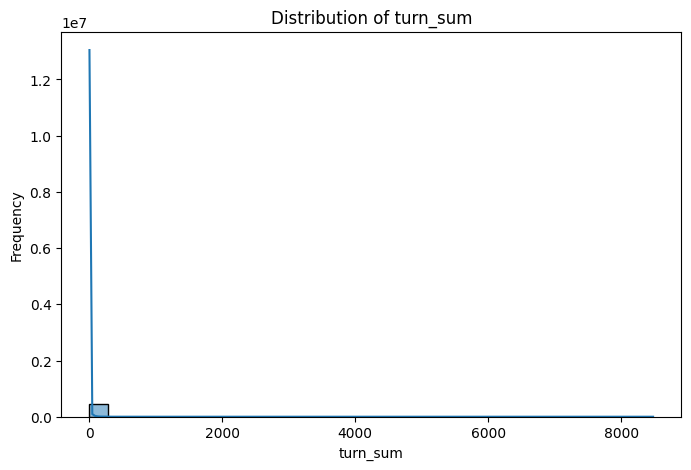

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램 + KDE
plt.figure(figsize=(8,5))
sns.histplot(df_day["turn_sum"], bins=30, kde=True)
plt.title("Distribution of turn_sum")
plt.xlabel("turn_sum")
plt.ylabel("Frequency")
plt.show()


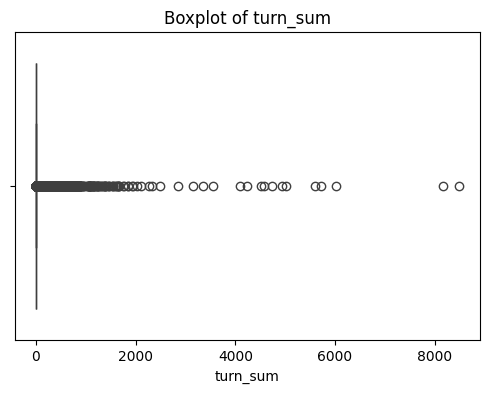

In [20]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df_day["turn_sum"])
plt.title("Boxplot of turn_sum")
plt.show()

In [21]:
(df_day["turn_sum"]==0).sum()

304268

In [22]:
zero_count = (df_day["turn_sum"] == 0).sum()
nonzero_count = (df_day["turn_sum"] > 0).sum()
zero_ratio = zero_count / len(df_day)

print(f"0인 비율: {zero_ratio:.2%} ({zero_count:,}개)")
print(f"0이 아닌 비율: {1-zero_ratio:.2%} ({nonzero_count:,}개)")

0인 비율: 67.66% (304,268개)
0이 아닌 비율: 32.34% (145,422개)


In [27]:
# 아이디별 전환수 합계
id_sum = df_day.groupby("unique_id", as_index=False)["turn_sum"].sum()

# 전환수 합계 > 0인 아이디 개수
positive_count = (id_sum["turn_sum"] > 0).sum()

# 전환수 합계 == 0인 아이디 개수
zero_count = (id_sum["turn_sum"] == 0).sum()

print("전환수 > 0인 아이디 수:", positive_count)
print("전환수 == 0인 아이디 수:", zero_count)

전환수 > 0인 아이디 수: 11073
전환수 == 0인 아이디 수: 12993


In [24]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 449690 entries, 0 to 460174
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   unique_id      449690 non-null  int64         
 1   rpt_time_date  449690 non-null  datetime64[ns]
 2   turn_sum       449690 non-null  int64         
 3   ads_idx        449690 non-null  int64         
 4   mda_idx        449690 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 20.6 MB


### 타깃값 로그 변환

In [66]:
import numpy as np

# turn_sum 로그 변환 (0 포함 가능) y=log(1+x)
df_day["turn_sum_log"] = np.log1p(df_day["turn_sum"])

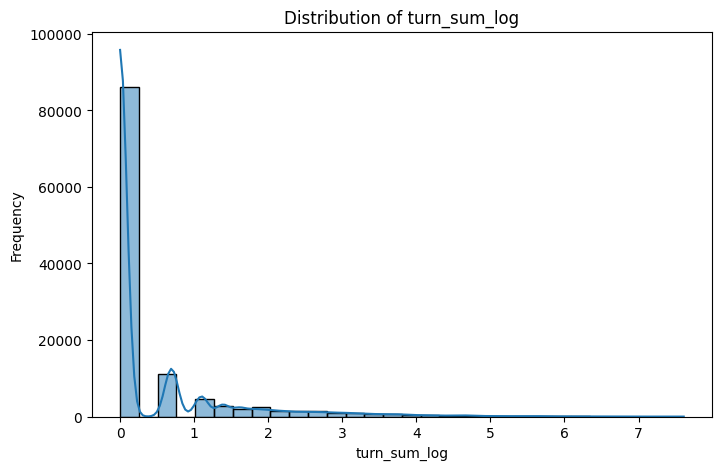

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램 + KDE
plt.figure(figsize=(8,5))
sns.histplot(df_day["turn_sum_log"], bins=30, kde=True)
plt.title("Distribution of turn_sum_log")
plt.xlabel("turn_sum_log")
plt.ylabel("Frequency")
plt.show()


### 모델링

#### 데이터 분리

In [68]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118320 entries, 601 to 263677
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   unique_id      118320 non-null  int64         
 1   rpt_time_date  118320 non-null  datetime64[ns]
 2   turn_sum       118320 non-null  int64         
 3   ads_idx        118320 non-null  int64         
 4   mda_idx        118320 non-null  int64         
 5   turn_sum_log   118320 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 6.3 MB


In [69]:
# 광고별 데이터 날짜 길이
ad_days = df_day.groupby('unique_id')['rpt_time_date'].nunique()

# 통계량 확인
stats = ad_days.describe()  # count, mean, std, min, 25%, 50%, 75%, max 포함
print(stats)

count    1312.000000
mean       90.182927
std        96.264883
min         1.000000
25%        34.000000
50%        57.000000
75%        87.000000
max       399.000000
Name: rpt_time_date, dtype: float64


In [ ]:
# 1️⃣ 날짜가 30일 이상인 것만 가져가기 정규분포에 의해서
date_counts = df_day.groupby("unique_id")["rpt_time_date"].nunique()
valid_ids = date_counts[date_counts >= 30].index
df_day = df_day[df_day["unique_id"].isin(valid_ids)]

In [72]:
#예측할 고유 ID 개수 확인
print("고유 광고 수 (ads_idx):", df_day["ads_idx"].nunique())
print("고유 MDA 수 (mda_idx):", df_day["mda_idx"].nunique())
print("고유 unique_id 수:", df_day["unique_id"].nunique())

고유 광고 수 (ads_idx): 247
고유 MDA 수 (mda_idx): 110
고유 unique_id 수: 1028


In [74]:

# 확인할 날짜 리스트
dates_to_check = ['2024-08-27', '2024-08-28', '2024-08-29']

for date_str in dates_to_check:
    date = pd.to_datetime(date_str)
    missing_count = df_day[~df_day['unique_id'].isin(
        df_day[df_day['rpt_time_date'] == date]['unique_id']
    )]['unique_id'].nunique()
    
    print(f"{date_str} 데이터 없는 광고 수:", missing_count)

2024-08-27 데이터 없는 광고 수: 159
2024-08-28 데이터 없는 광고 수: 138
2024-08-29 데이터 없는 광고 수: 0


In [93]:
import pandas as pd

# 오늘 날짜
end_date = pd.to_datetime("2024-08-29")

filled_list = []

for uid, group in df_day.groupby("unique_id"):
    # 아이디별 시작 날짜 ~ 8/29까지 생성
    start_date = group['rpt_time_date'].min()
    all_dates = pd.date_range(start=start_date, end=end_date, freq="D")

    # 날짜 기준으로 reindex
    g = group.set_index("rpt_time_date").reindex(all_dates)

    # flag: 기존 데이터 있으면 1, 없으면 0
    g["flag"] = g["turn_sum"].notna().astype(int)

    # 원래 값 없던 날은 turn_sum = 0
    g["turn_sum"] = g["turn_sum"].fillna(0)
    g["turn_sum_log"] = g["turn_sum_log"].fillna(0)


    # ID 다시 넣기
    g["unique_id"] = uid
    g = g.reset_index().rename(columns={"index": "rpt_time_date"})

    filled_list.append(g)

df_fill = pd.concat(filled_list, ignore_index=True)

print(df_fill.head(15))


   rpt_time_date  unique_id  turn_sum  ads_idx  mda_idx  turn_sum_log    year  \
0     2024-08-13   66670054       5.0   6667.0     54.0      1.791759  2024.0   
1     2024-08-14   66670054      12.0   6667.0     54.0      2.564949  2024.0   
2     2024-08-15   66670054      20.0   6667.0     54.0      3.044522  2024.0   
3     2024-08-16   66670054       9.0   6667.0     54.0      2.302585  2024.0   
4     2024-08-17   66670054      16.0   6667.0     54.0      2.833213  2024.0   
5     2024-08-18   66670054      12.0   6667.0     54.0      2.564949  2024.0   
6     2024-08-19   66670054       0.0      NaN      NaN      0.000000     NaN   
7     2024-08-20   66670054       0.0   6667.0     54.0      0.000000  2024.0   
8     2024-08-21   66670054       1.0   6667.0     54.0      0.693147  2024.0   
9     2024-08-22   66670054       4.0   6667.0     54.0      1.609438  2024.0   
10    2024-08-23   66670054       2.0   6667.0     54.0      1.098612  2024.0   
11    2024-08-24   66670054 

In [101]:
df_fill['year'] = df_fill['rpt_time_date'].dt.year
df_fill['month'] = df_fill['rpt_time_date'].dt.month
df_fill['day'] = df_fill['rpt_time_date'].dt.day


In [88]:
df_fill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28277 entries, 0 to 28276
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   rpt_time_date  28277 non-null  datetime64[ns]
 1   unique_id      28277 non-null  int64         
 2   turn_sum       28277 non-null  float64       
 3   ads_idx        23156 non-null  float64       
 4   mda_idx        23156 non-null  float64       
 5   turn_sum_log   23156 non-null  float64       
 6   year           23156 non-null  float64       
 7   month          23156 non-null  float64       
 8   day            23156 non-null  float64       
 9   flag           28277 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 2.2 MB


In [102]:
train_list = []
valid_list = []
test_list = []

for ad_id, group in df_fill.groupby("unique_id"):
    group = group.sort_values("rpt_time_date")
    
    # 마지막 1일 → test, 그 전날 → valid, 나머지 → train
    test = group.tail(2)
    valid = group.iloc[-4:-2]
    train = group.iloc[:-2]
    
    train_list.append(train)
    valid_list.append(valid)
    test_list.append(test)

train_df = pd.concat(train_list)
valid_df = pd.concat(valid_list)
test_df = pd.concat(test_list)

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)
print("Test shape:", test_df.shape)


Train shape: (26236, 10)
Valid shape: (1995, 10)
Test shape: (2041, 10)


In [100]:
valid_df

,rpt_time_date,unique_id,turn_sum,ads_idx,mda_idx,turn_sum_log,year,month,day,flag
13,2024-08-26,66670054,7.0,6667.0,54.0,2.079442,2024.0,8.0,26.0,1
14,2024-08-27,66670054,7.0,6667.0,54.0,2.079442,2024.0,8.0,27.0,1
30,2024-08-26,66670213,97.0,6667.0,213.0,4.584967,2024.0,8.0,26.0,1
31,2024-08-27,66670213,169.0,6667.0,213.0,5.135798,2024.0,8.0,27.0,1
47,2024-08-26,66670270,0.0,6667.0,270.0,0.000000,2024.0,8.0,26.0,1
...,...,...,...,...,...,...,...,...,...,...
28262,2024-08-27,924760653,0.0,92476.0,653.0,0.000000,2024.0,8.0,27.0,1
28265,2024-08-26,924760761,6.0,92476.0,761.0,1.945910,2024.0,8.0,26.0,1
28266,2024-08-27,924760761,6.0,92476.0,761.0,1.945910,2024.0,8.0,27.0,1
28269,2024-08-26,924770761,1.0,92477.0,761.0,0.693147,2024.0,8.0,26.0,1


In [ ]:
# df_model = df_day[['year','month','day','unique_id','turn_sum_log']]

In [95]:
features = ['year','month','day','unique_id','flag']  # 필요하면 요일/월 등 추가 가능
target = "turn_sum_log"

In [91]:
# 로그변환된 target을 지수변환하기 위한 함수
def exp_transform(y):
    return np.expm1(y)  # log1p -> expm1, 0 값도 안전하게 처리

# MAPE 계산 함수
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100

#### RandomForestRegressor

In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# 모델 초기화
rf = RandomForestRegressor()

# 1️⃣ Train 데이터 학습
rf.fit(train_df[features], train_df[target])

# 2️⃣ Train 데이터 예측
pred_val = rf.predict(valid_df[features])

pred_val_exp = exp_transform(pred_val)
y_train_exp = exp_transform(valid_df[target])

# 3️⃣ Train 성능 평가
mse_train = mean_squared_error(y_train_exp, pred_val_exp)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_exp, pred_val_exp)
r2_train = r2_score(y_train_exp, pred_val_exp)
mape_train = mean_absolute_percentage_error(y_train_exp, pred_val_exp)

print("valid 성능:")
print(f"R2: {r2_train:.4f}, MAE: {mae_train:.2f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}%")



valid 성능:
R2: 0.8276, MAE: 0.89, MSE: 25.03, RMSE: 5.00, MAPE: 259105996.36%


In [104]:
# 4️⃣ Test 데이터 예측
pred_test = rf.predict(test_df[features])

pred_test_exp = exp_transform(pred_test)
y_test_exp = exp_transform(test_df[target])

# 5️⃣ Test 성능 평가
mse_test = mean_squared_error(y_test_exp, pred_test_exp)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_exp, pred_test_exp)
r2_test = r2_score(y_test_exp, pred_test_exp)
mape_test = mean_absolute_percentage_error(y_test_exp, pred_test_exp)

print("Test 성능:")
print(f"R2: {r2_test:.4f}, MAE: {mae_test:.2f}, MSE: {mse_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}%")

Test 성능:
R2: 0.5410, MAE: 2.00, MSE: 91.66, RMSE: 9.57, MAPE: 1715956864.09%


#### XGBoost

In [89]:
import xgboost
print(xgboost.__version__)

2.1.1


In [107]:
import xgboost as xgb

# 모델 초기화
xgb_model = xgb.XGBRegressor(enable_categorical=True)

# 1️⃣ Train 데이터 학습
xgb_model.fit(train_df[features], train_df[target])

# 2️⃣ Train 데이터 예측
pred_val = xgb_model.predict(valid_df[features])

pred_val_exp = exp_transform(pred_val)
y_train_exp = exp_transform(valid_df[target])

# 3️⃣ Train 성능 평가
mse_train = mean_squared_error(y_train_exp, pred_val_exp)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_exp, pred_val_exp)
r2_train = r2_score(y_train_exp, pred_val_exp)
mape_train = mean_absolute_percentage_error(y_train_exp, pred_val_exp)

print("valid 성능:")
print(f"R2: {r2_train:.4f}, MAE: {mae_train:.2f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}%")



valid 성능:
R2: 0.2658, MAE: 2.17, MSE: 106.61, RMSE: 10.33, MAPE: 1917552240.31%


In [108]:
# 4️⃣ Test 데이터 예측
pred_test = xgb_model.predict(test_df[features])

pred_test_exp = exp_transform(pred_test)
y_test_exp = exp_transform(test_df[target])

# 5️⃣ Test 성능 평가
mse_test = mean_squared_error(y_test_exp, pred_test_exp)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_exp, pred_test_exp)
r2_test = r2_score(y_test_exp, pred_test_exp)
mape_test = mean_absolute_percentage_error(y_test_exp, pred_test_exp)

print("Test 성능:")
print(f"R2: {r2_test:.4f}, MAE: {mae_test:.2f}, MSE: {mse_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}%")

Test 성능:
R2: 0.2054, MAE: 2.89, MSE: 158.69, RMSE: 12.60, MAPE: 4258121525.07%


#### LGBM

In [109]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor()


# 1️⃣ Train 데이터 학습
lgb_model.fit(train_df[features], train_df[target])

# 2️⃣ Train 데이터 예측
pred_val = lgb_model.predict(valid_df[features])

pred_val_exp = exp_transform(pred_val)
y_train_exp = exp_transform(valid_df[target])

# 3️⃣ Train 성능 평가
mse_train = mean_squared_error(y_train_exp, pred_val_exp)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_exp, pred_val_exp)
r2_train = r2_score(y_train_exp, pred_val_exp)
mape_train = mean_absolute_percentage_error(y_train_exp, pred_val_exp)

print("valid 성능:")
print(f"R2: {r2_train:.4f}, MAE: {mae_train:.2f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}%")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 26236, number of used features: 4
[LightGBM] [Info] Start training from score 0.324727
valid 성능:
R2: 0.2253, MAE: 2.20, MSE: 112.49, RMSE: 10.61, MAPE: 1849816450.26%


In [110]:
# 4️⃣ Test 데이터 예측
pred_test = lgb_model.predict(test_df[features])

pred_test_exp = exp_transform(pred_test)
y_test_exp = exp_transform(test_df[target])

# 5️⃣ Test 성능 평가
mse_test = mean_squared_error(y_test_exp, pred_test_exp)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_exp, pred_test_exp)
r2_test = r2_score(y_test_exp, pred_test_exp)
mape_test = mean_absolute_percentage_error(y_test_exp, pred_test_exp)

print("Test 성능:")
print(f"R2: {r2_test:.4f}, MAE: {mae_test:.2f}, MSE: {mse_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}%")

Test 성능:
R2: 0.1899, MAE: 2.79, MSE: 161.78, RMSE: 12.72, MAPE: 2900452557.87%
